In [1]:
#import packages required to run the code
import requests
from bs4 import BeautifulSoup
import csv
import nltk, string
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords 
import threading
from threading import Thread
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
import math
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics

C:\Users\kriti\Anaconda2\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
#Amazon and Best Buy URL for 2 products
amazon_home_url={'Samsung S8 Unlocked Midnight Black':'https://www.amazon.com/Samsung-Galaxy-S8-Unlocked-64GB/dp/B06Y14T5YW',
                'Moto g5 Plus':'https://www.amazon.com/Moto-Plus-5th-Generation-Lockscreen/dp/B01N6NTIRH'}
amazon_review_url={'Samsung S8 Unlocked Midnight Black':'https://www.amazon.com/Samsung-Galaxy-S8-Unlocked-64GB/product-reviews/B06Y14T5YW/ref=cm_cr_getr_d_show_all?ie=UTF8&reviewerType=all_reviews&pageNumber=1',
                  'Moto g5 Plus':'https://www.amazon.com/Moto-Plus-5th-Generation-Lockscreen/product-reviews/B01NBRN2YI/ref=cm_cr_getr_d_show_all?ie=UTF8&reviewerType=all_reviews&pageNumber=1'}
bestbuy_home_url={'Samsung S8 Unlocked Midnight Black':'https://www.bestbuy.com/site/samsung-galaxy-s8-64gb-unlocked-midnight-black/5803741.p?skuId=5803741',
                 'Moto g5 Plus':'https://www.bestbuy.com/site/motorola-moto-g-plus-5th-gen-4g-lte-with-64gb-memory-cell-phone-unlocked-lunar-gray/5764600.p?skuId=5764600'}
bestbuy_review_url={'Samsung S8 Unlocked Midnight Black':'https://www.bestbuy.com/site/reviews/samsung-galaxy-s8-64gb-unlocked-midnight-black/5803741',
                   'Moto g5 Plus':'https://www.bestbuy.com/site/reviews/motorola-moto-g-plus-5th-gen-4g-lte-with-64gb-memory-cell-phone-unlocked-lunar-gray/5764600'}

#A few global variables which will be used in the code later on
a_url_home=""
a_url_review=""
b_url_home=""
b_url_review=""
score_a=[]
title_a=[]
date_a=[]
reviews_a=[]

score_b=[]
title_b=[]
date_b=[]
reviews_b=[]


#headers for requesting the page content
headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}


#Function to calculate the results for all the features/label of each website with respect to a common multiplier
def calculateResults(target_names,reviewsSentTokenize,labelled1,sentiments): 
    list1=[]
    sid = SentimentIntensityAnalyzer() 
    #code to calculate compound intensity of each review
    for sentence in reviewsSentTokenize:
        ss = sid.polarity_scores(sentence)
        list1.append(ss['compound']) 
    sumList=[]
    for i in range(0,len(target_names)):
        sumList.append(0);   
        
    #code to add compound intensities of all the positive reviews as respect to each label
    for x in range(0,len(target_names)):
        for j in range(0,len(labelled1)):
            if sentiments[j]=='positive':
                if target_names[x] in labelled1[j]:
                    sumList[x]=sumList[x]+list1[j]
    intensity=0
    #code to find a common multiplier
    for x in sumList:
        intensity+=x
    multiplier=1/intensity
    result=[]
    #code to calculate the result
    for x in sumList:
        result.append(x*multiplier)    
    return result

#function to plot a graph between result and sentiment count of each sentiment for all the features
#this function is taking choice as a parameter which can have 2 values - Best Buy and Amazon 
#Thus, this will plot graph of result vs sentiment for both the websites
def plotSentimentsGraph(target_names,labelled1,sentiments,choice):
    n_groups = len(target_names)
    fig, ax = plt.subplots()
    index=np.arange(n_groups)
    bar_width = 0.2
    opacity = 0.8
    countSent={}
    for x in target_names:
        cp=[]
        cn=[]
        cnn=[]
        for j in range(0,len(labelled1)):
            if x in labelled1[j]:
                if sentiments[j]=='positive':
                    cp.append(sentiments[j])
                elif sentiments[j]=='negative':
                    cn.append(sentiments[j])
                else:
                    cnn.append(sentiments[j])
        countSent[x]=[cp,cn,cnn]
    countKeySent={}
    for key,value in countSent.items():
        p=0
        n=0
        nt=0
        for i in range(0,len(value)):
            if i==0:
                p+=len(value[i])
            elif i==1:
                n+=len(value[i])
            else:
                nt+=len(value[i])
        countKeySent[key]=[p,n,nt]
    positive=[]
    negative=[]
    neutral=[]
    for key,value in countKeySent.items():
        positive.append(value[0])
        negative.append(value[1])
        neutral.append(value[2])   
    rects1 = plt.bar(index, positive, bar_width,
                     alpha=opacity,
                     color='b',
                     label='Positive')
    rects2 = plt.bar(index + bar_width, negative, bar_width,
                     alpha=opacity,
                     color='g',
                     label='Negative')
    rects3 = plt.bar(index + bar_width+bar_width, neutral, bar_width,
                     alpha=opacity,
                     color='r',
                     label='Neutral')
    plt.xlabel('Features')
    plt.ylabel('Sentiments')
    plt.title('Result vs Sentiment count '+choice)
    plt.xticks(index + bar_width, (target_names))
    plt.legend()
    plt.tight_layout()
    plt.show()
    

#This function will recommend a website based on results obtained from function calculateResults() for each website
#It will compare the results of each feature for both the websites and will recommend one website based on each feature
#It will also recommend only one website based on the results of above line. 
#i.e. which website is recommended most according to all the features 
def recommendationCalc(target_names,resultAmazon,resultBestBuy):
    recommendation=[]
    for x in range(0,len(resultAmazon)):
        if resultAmazon[x]>resultBestBuy[x]:
            recommendation.append("Amazon")
        elif resultAmazon[x]<resultBestBuy[x]:
            recommendation.append("Best Buy")
        else:
            recommendation.append("Any")
    overall=""
    cb=0
    ca=0
    cany=0
    for y in recommendation:
        if y=="Best Buy":
            cb+=1
        elif y=="Amazon":
            ca+=1
        else:
            cany+=1
    if cb>ca and cb>cany:
        overall="Best Buy"
    elif ca>cb and ca>cany:
        overall="Amazon"
    else:
        overall="Any"
    s="\t\t"
    for i in range(0,len(target_names)):
        s+=target_names[i].upper()+"\t"
    print(s)
    bestbuys="Best Buy\t"
    amazons="Amazon\t\t"
    rec="Recommendation\t"
    for x in range(0,len(resultAmazon)):
        bestbuys+=str("%.5f" % round(resultBestBuy[x],5))+"\t\t"
        amazons+=str("%.5f" % round(resultAmazon[x],5))+"\t\t"
        rec+=recommendation[x]+"\t\t"
    print(bestbuys)
    print(amazons)
    print(rec)
    print"\nOverall recommendation\t=>",overall.upper()
    
#This function will plot a graph between result which is calculated from calculateResults() function and features
#for both the websites
def resultsGraph(target_names,resultAmazon,resultBestBuy): 
    n_groups = len(target_names)
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.2
    opacity = 0.8
    rects1 = plt.bar(index, resultAmazon, bar_width,
                     alpha=opacity,
                     color='b',
                     label='Amazon')
    rects2 = plt.bar(index + bar_width, resultBestBuy, bar_width,
                     alpha=opacity,
                     color='g',
                     label='Best Buy')
    plt.xlabel('Features')
    plt.ylabel('Result')
    plt.title('Result vs Features combined')
    plt.xticks(index + bar_width, (target_names))
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
#Function used for classification of data as per labels
def classifyData(reviewsSentTokenize,synonym_dict,labels):
    #splitting the data for training and testing
    splitRange=int(math.ceil(0.8*len(reviewsSentTokenize)))
    X_train = np.array(reviewsSentTokenize[0:splitRange])
    target_names=[]
    for key in synonym_dict.keys():
        target_names.append(key)
    Y_train=np.full((splitRange,len(target_names)),0)
    labelled1=[] 
    count1=0
    # The target needs to be an indicator matrix y_train
    # where y_train[i,j] means the jth label of sample i
    for x in range(0,splitRange):   
        labelled=[]
        count2=0
        for key,value in synonym_dict.items():
            for i in value:
                if i in reviewsSentTokenize[x]:
                    Y_train[count1,count2]=1
                    break;
            count2+=1
        count1+=1     
    X_test = np.array(reviewsSentTokenize[splitRange:len(reviewsSentTokenize)+1])   
    Y_test=np.full((len(reviewsSentTokenize)-splitRange,len(target_names)),0)
    labelled1=[] 
    count1=0
    for x in range(splitRange,len(reviewsSentTokenize)):   
        labelled=[]
        count2=0
        for key,value in synonym_dict.items():
            for i in value:
                if i in reviewsSentTokenize[x]:
                    Y_test[count1,count2]=1
                    break;
            count2+=1
        count1+=1  
    classifier = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', OneVsRestClassifier(LinearSVC()))])
    classifier.fit(X_train, Y_train)
    predicted = classifier.predict(X_test)
    predicted_labels_final=[]
    for idx, p in enumerate(predicted):
        predicted_labels=[]
        for x in range(0,len(target_names)):
            if p[x]==1:
                predicted_labels.append(target_names[x])
        if len(predicted_labels)==0:
            predicted_labels_final.append(" ")
        else:
            predicted_labels_final.append(predicted_labels)             
    return predicted_labels_final

#This function use VADER for sentiment analysis and based on their compound intensity reviews is classified as 
#positive, negative or neutral
def sentimentAnalyzer(rows):
    list1=[]
    review=[]
    sid = SentimentIntensityAnalyzer() 
    for sentence in rows:
        ss = sid.polarity_scores(sentence)
        list1.append(ss['compound'])
    for x in range(len(list1)):
        if(list1[x] >= (0.5)):
            review.append("positive")
        elif(list1[x] <= (-0.5)):
            review.append("negative")
        else:
            review.append("neutral")
    return (review)

#This function is used for cleaning the raw data by tokenizing and lemmatizing the data as sentences
def getTokens(docs):
        stop_words = stopwords.words('english')
        tokens=[]
        for sent in nltk.sent_tokenize(docs.lower()):    
            for words in sent.split():
                if words not in stop_words and words not in string.punctuation:
                    tokens.append(words)
        tagged_tokens= nltk.pos_tag(tokens)
        wordnet_lemmatizer = WordNetLemmatizer()
        le_words=[wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for (word, tag) in tagged_tokens]
        return le_words

#Function is used to find the part of speech of a word
def get_wordnet_pos(pos_tag):    
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    
    elif pos_tag.startswith('V'):
        return wordnet.VERB

    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
#This function is used to set the soup object after requesting the page for Best Buy
def setSoupBestbuy(url):
    page = requests.get(url,headers=headers)
    if page.status_code==200:
        soup = BeautifulSoup(page.content, 'html.parser')
        return soup
    else:
        print (Error)       

#This function is used to set the soup object after requesting the page for Amazon
def setSoupAmazon(url):
    page = requests.get(url,headers=headers)
    if page.status_code==200:
        soup = BeautifulSoup(page.content, 'html.parser')
        return soup
    else:
        print (Error)
    
#This function will scrape the reviews from Amazon
def getReviewsAmazon(url_review):
    print("Fetching reviews from Amazon!")
    count=0
    while (url_review!=None):
        count+=1
        soup=setSoupAmazon(url_review)
        divs=soup.select("div#cm_cr-review_list div.a-section.review")
        for idx, div in enumerate(divs):
            date_a.append(div.select("span.a-size-base.a-color-secondary.review-date")[0].get_text().encode('ascii','ignore'))
            score_a.append(div.select("span.a-icon-alt")[0].get_text().encode('ascii','ignore'))
            title_a.append(div.select("a.a-size-base.a-link-normal.review-title.a-color-base.a-text-bold")[0].get_text().encode('ascii','ignore'))
            reviews_a.append(div.select("span.a-size-base.review-text")[0].get_text().encode('ascii','ignore'))
            
        tag=soup.find("li",class_="a-selected page-button")
        if tag!=None:
            divTag=(((tag).find_next_sibling("li", class_="page-button")))
        else:
            url_review="https://www.amazon.com/Moto-Plus-5th-Generation-Lockscreen/product-reviews/B01NBRN2YI/ref=cm_cr_arp_d_paging_btm_"+str(count+1)+"?ie=UTF8&pageNumber="+str(count+1)+"&reviewerType=all_reviews"
            continue;
            
        if(divTag!=None):
            t=0;
            for tag in divTag:
                t+=1
                if "Next" not in tag.getText():
                    url_review="https://www.amazon.com"+tag.get('href')
                else:
                    url_review=None
        else:
            url_review=None
    
    rows=zip(date_a, score_a, title_a, reviews_a)
    with open ("amazon.csv",'wb') as az:
        writer=csv.writer(az)
        writer.writerows(rows)
    print("Amazon data Scraping completed!")

#This function is used to fetch Price from home page of Amazon for that product
def mainPageContentAmazon(url_home):
    soup=setSoupAmazon(url_home)
    price=None
    price_div=soup.select("span#priceblock_ourprice")
#     price_div=soup.select("div#price table.a-lineitem tbody tr.priceblock_ourprice_row td.a-span12 span#priceblock_ourprice")
    if price_div!=[]:
        price=price_div[0].get_text()
    print ("Price at amazon-",price)

#This function is used to fetch Price from home page of Bestbuy for that product
def mainPageContentBestbuy(url_home):
    soup=setSoupBestbuy(url_home)
    price=None
    price_div=soup.select("div.pb-hero-price.pb-purchase-price span")
    if price_div!=[]:
        price=price_div[0].get_text()
    print("Price at best buy-",price)
    
#This function will scrape the reviews from Best buy
def getReviewsBestbuy(url_review):
    print("Fetching reviews from Best Buy!")
    while(url_review!=None):
        soup=setSoupBestbuy(url_review)
        divs=soup.select("div.review-item-feedback")
        for idx,div in enumerate(divs):
            score_b.append(div.select("span.reviewer-score")[0].get_text().encode('ascii','ignore'))
            title_b.append(div.select("h4.col-md-9.col-sm-9.col-xs-12.title")[0].get_text().encode('ascii','ignore'))
            date_b.append(div.select("div.review-date")[0].get_text().encode('ascii','ignore'))
            reviews_b.append(div.select("p.pre-white-space")[0].get_text().encode('ascii','ignore'))
        divTag=(((soup.find("li",class_="page active")).find_next_sibling("li", class_="page")))
        for tag in divTag:
            link=tag.get('href')
            if(link=='javascript:void(0);'):
                url_review=None
            else:
                url_review=link
    rows=zip(date_b, score_b, title_b, reviews_b)
    
    with open ("bestbuy.csv",'wb') as bb:
        writer=csv.writer(bb)
        writer.writerows(rows)
    print("Best Buy data scraping completed!")

#function to call methods for amazon website to scrape the data
def amazon():
    mainPageContentAmazon(a_url_home)
    getReviewsAmazon(a_url_review)
        
#function to call methods for Best buy website to scrape the data
def bestbuy():
    mainPageContentBestbuy(b_url_home)
    getReviewsBestbuy(b_url_review)
    
#Main method from where the execution of code starts
if __name__=="__main__":
    #Prompt user for their choice as this system recommends website for 2 products
    x=input("1. Samsung S8 Unlocked Midnight Black\n2. Moto g5 Plus\n")
    #Set URL as per user's choice
    if(x==1):
        a_url_home=amazon_home_url['Samsung S8 Unlocked Midnight Black']
        a_url_review=amazon_review_url['Samsung S8 Unlocked Midnight Black']
        b_url_home=bestbuy_home_url['Samsung S8 Unlocked Midnight Black']
        b_url_review=bestbuy_review_url['Samsung S8 Unlocked Midnight Black']
    if (x==2):
        a_url_home=amazon_home_url['Moto g5 Plus']
        a_url_review=amazon_review_url['Moto g5 Plus']
        b_url_home=bestbuy_home_url['Moto g5 Plus']
        b_url_review=bestbuy_review_url['Moto g5 Plus']
    
    #Manually calculated labels/features and their synonyms
    target_names = ['price','customer service','delivery','faulty product']
    synonym_dict={'price':['price','expensive','cheap','cost','value','money','rising','rose','rise'],
                  'customer service':['customer service','return','replace','refund','replacement'],
                  'delivery':['delivery','shipping','consignment','package'],
                  'faulty product':['faulty product','broken','unlocked','defective']}
    #Below code is for multithreading so that reviews can be scraped from both the websites simultaneously
    try:
        Thread(target=amazon).start()
        Thread(target=bestbuy).start()
    except:
        print "Error: unable to start thread"
        
    

1. Samsung S8 Unlocked Midnight Black
2. Moto g5 Plus
2
('Price at best buy-', u'$299.99')
Fetching reviews from Best Buy!
('Price at amazon-', u'$239.99')
Fetching reviews from Amazon!
Best Buy data scraping completed!
Amazon data Scraping completed!


In [3]:
#Amazon Calculation code

#Read the raw data which is scraped from amazon's website
headers=['date','rating','heading','review']
data=pd.read_csv("amazon.csv",names=headers,header=0, delimiter=",")
text=data.review.tolist()
dateF=data.date.tolist()
ratingF=data.rating.tolist()
reviews=[]
#Call method getTokens to clean the data
for rev in text:
    reviews.append(getTokens(rev))
reviewsSentTokenize_Amazon=[]
sent=""
for i in reviews:
    sent=""
    for j in i:
        sent=sent+" "+j
    reviewsSentTokenize_Amazon.append(sent)
date_formatted=[]
#Code for data standardization [stripping irrelevant values from the actual data]
for x in dateF:
    date_formatted.append(x.replace('on ',''))    
rating_formatted=[]
for x in ratingF:
    rating_formatted.append(x.replace('out of 5 stars',''))
labelled1_Amazon=[]
zz=[]

#Code for assigning the labels manually
for x in reviewsSentTokenize_Amazon:  
    zz=x.split(" ")
    labelled=[]
    for key,value in synonym_dict.items():
        for i in value:
            if i in zz:
                labelled.append(key)
                break;
    if len(labelled)==0:
        labelled1_Amazon.append(" ")
    else:
        labelled1_Amazon.append(labelled)
        
#function call for sentiment analysis
sentiments_Amazon=sentimentAnalyzer(reviewsSentTokenize_Amazon)
rowsUn=[]
for x in range(0,len(date_formatted)):
    rows=[date_formatted[x],rating_formatted[x],reviewsSentTokenize_Amazon[x],sentiments_Amazon[x]]
    rowsUn.append(rows)
    
#creating file for unlabelled but cleaned data
with open ("amazon_unlabelled.csv",'wb') as az:
    writer=csv.writer(az,delimiter=',')
    writer.writerows(rowsUn)
rowsLab=[]
for x in range(0,len(date_formatted)):
    rows=[date_formatted[x],rating_formatted[x],reviewsSentTokenize_Amazon[x],sentiments_Amazon[x],labelled1_Amazon[x]]
    rowsLab.append(rows)
    
#creating file for labelled and cleaned data
with open ("amazon_labelled.csv",'wb') as az:
    writer=csv.writer(az,delimiter=',')
    writer.writerows(rowsLab)
predicted_labels_final=classifyData(reviewsSentTokenize_Amazon,synonym_dict,labelled1_Amazon)
t=[]
splitRange=int(math.ceil(0.8*len(reviewsSentTokenize_Amazon)))
for x in range(splitRange,len(reviewsSentTokenize_Amazon)):
    t.append(labelled1_Amazon[x])
testing=[]
for x in range(0,len(predicted_labels_final)):
    rows=[t[x],predicted_labels_final[x]]
    testing.append(rows)
    
#creating file for testing classification accuracy
with open ("amazon_classification_testing.csv",'wb') as az:
    writer=csv.writer(az,delimiter=',')
    writer.writerows(testing)
    
#function call to calculate results for Amazon
resultAmazon=calculateResults(target_names,reviewsSentTokenize_Amazon,labelled1_Amazon,sentiments_Amazon)
print("Calculation Amazon Completed!")


Calculation Amazon Completed!


In [4]:
#Best Buy calculation code

#Read the raw data which is scraped from best buy's website
headers=['date','rating','heading','review']
data=pd.read_csv("bestbuy.csv",names=headers,header=0, delimiter=",")
text=data.review.tolist()
dateF=data.date.tolist()
ratingF=data.rating.tolist()
reviews=[]

#Call method getTokens to clean the data
for rev in text:
    reviews.append(getTokens(rev)) 
reviewsSentTokenize=[]
sent=""
for i in reviews:
    sent=""
    for j in i:
        sent=sent+" "+j
    reviewsSentTokenize.append(sent)
labelled1=[] 
zz=[]

#Code for assigning the labels manually
for x in reviewsSentTokenize:   
    labelled=[]
    zz=x.split(" ")
    for key,value in synonym_dict.items():
        for i in value:
            if i in zz:
                labelled.append(key)
                break;
    if len(labelled)==0:
        labelled1.append(" ")
    else:
        labelled1.append(labelled)

#function call for sentiment analysis
sentiments=sentimentAnalyzer(reviewsSentTokenize)     
rowsUn=[]
for x in range(0,len(dateF)):
    rows=[dateF[x],ratingF[x],reviewsSentTokenize[x],sentiments[x]]
    rowsUn.append(rows)   
    
#creating file for unlabelled but cleaned data
with open ("bestbuy_unlabelled.csv",'wb') as az:
    writer=csv.writer(az,delimiter=',')
    writer.writerows(rowsUn)
rowsLab=[]
for x in range(0,len(dateF)):
    rows=[dateF[x],ratingF[x],reviewsSentTokenize[x],sentiments[x],labelled1[x]]
    rowsLab.append(rows)    
    
#creating file for labelled and cleaned data
with open ("bestbuy_labelled.csv",'wb') as az:
    writer=csv.writer(az,delimiter=',')
    writer.writerows(rowsLab)
predicted_labels_final=classifyData(reviewsSentTokenize,synonym_dict,labelled1)
t=[]
splitRange=int(math.ceil(0.8*len(reviewsSentTokenize)))
for x in range(splitRange,len(reviewsSentTokenize)):
    t.append(labelled1[x])    
testing=[]
for x in range(0,len(predicted_labels_final)):
    rows=[t[x],predicted_labels_final[x]]
    testing.append(rows)    
    
#creating file for testing classification accuracy
with open ("bestbuy_classification_testing.csv",'wb') as az:
    writer=csv.writer(az,delimiter=',')
    writer.writerows(testing)
    
#function call to calculate results for Best buy
resultBestBuy=calculateResults(target_names,reviewsSentTokenize,labelled1,sentiments)
print("Calculation Best Buy Completed!")


Calculation Best Buy Completed!


Plotting graphs


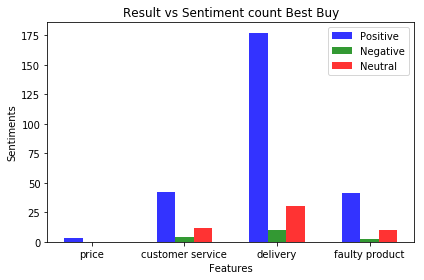

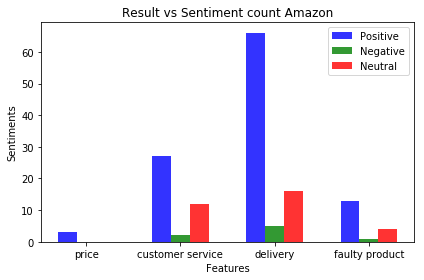

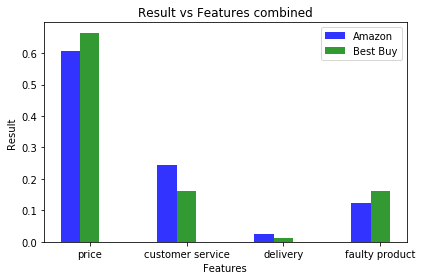

		PRICE	CUSTOMER SERVICE	DELIVERY	FAULTY PRODUCT	
Best Buy	0.66456		0.16214		0.01242		0.16088		
Amazon		0.60641		0.24527		0.02520		0.12313		
Recommendation	Best Buy		Amazon		Amazon		Best Buy		

Overall recommendation	=> ANY


In [5]:
print("Plotting graphs")
#bestbuy graph sentiments
plotSentimentsGraph(target_names,labelled1,sentiments,choice="Best Buy")
#bestbuy amazon sentiments
plotSentimentsGraph(target_names,labelled1_Amazon,sentiments_Amazon,choice="Amazon")    
#results graph
resultsGraph(target_names,resultAmazon,resultBestBuy)
#recommendation calculation
recommendationCalc(target_names,resultAmazon,resultBestBuy)